In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
import os
import csv
from helpers import *
from neural_network_model import NeuralNetwork
from neural_network_model import MultLayerNN

In [2]:
x0 = pd.read_csv('data/x_train.csv')
y0 = pd.read_csv('data/y_train.csv')
x_tr = x0.copy(deep=True)
y_tr = y0.copy(deep=True)

## Preprocessing

In [3]:
%%capture
#Converting the weights to kg, and asigning lacking answers to -1
array = x_tr["WEIGHT2"].values
pounds_indices  = ((array >= 50)*(array <= 999))
kg_indices      = ((array >= 9000)*(array <= 9998))
none_indices    = ((array == 7777) + (array == 9998))

x_tr["WEIGHT2"][pounds_indices] = 0.453592 * x_tr["WEIGHT2"][pounds_indices]
x_tr["WEIGHT2"][kg_indices] = x_tr["WEIGHT2"][kg_indices]%9000
x_tr["WEIGHT2"][none_indices] = np.nan

In [4]:
%%capture
#converting the height to meters, and asigning lacking answers to -1
array = x_tr["HEIGHT3"].values
imperial_indices    = ((array >= 200)*(array <= 711))
cm_indices          = ((array >= 9000)*(array <= 9998))
none_indices        = (array == 9998)

x_tr["HEIGHT3"][imperial_indices] = 0.3048 * x_tr["HEIGHT3"][imperial_indices]//100 + 0.0254 * x_tr["HEIGHT3"][imperial_indices]%100
x_tr["HEIGHT3"][cm_indices] = x_tr["HEIGHT3"][cm_indices]%9000
x_tr["HEIGHT3"][none_indices] = np.nan

In [5]:
#define a few functions used to clean and scale the data properly
def frequency_scaler(df, col):
    times_per_day   = (df[col]>=101)*(df[col]<=199)
    times_per_week  = (df[col]>=201)*(df[col]<=299)
    times_per_month = (df[col]>=301)*(df[col]<=399)
    none_indices    = (df[col] == 777) + (df[col] == 999)

    df[col][times_per_day]      = df[col][times_per_day]%100
    df[col][times_per_week]     = (df[col][times_per_week]%200)/7
    df[col][times_per_month]    = (df[col][times_per_month]%300)/30
    df[col][df[col]==300]       = 1/30
    df[col][df[col]==555]       = 0
    x_tr[col][none_indices] = np.nan

def weekly_frequency_scaler(df, col):
    times_per_week  = (df[col]>=101)*(df[col]<=199)
    times_per_month = (df[col]>=201)*(df[col]<=299)
    none_indices    = (df[col] == 777) + (df[col] == 999)

    df[col][times_per_week]     = (df[col][times_per_week]%100)/7
    df[col][times_per_month]    = (df[col][times_per_month]%200)/30
    df[col][df[col]==888]       = 0
    df[col][none_indices]       = np.nan

def hours_to_minutes(df, col):
    df[col][df[col].between(1, 759, "both")*df[col].between(800, 959, "both")] = 60*df[col][df[col].between(1, 759, "both")*df[col].between(800, 959, "both")]//100 + df[col][df[col].between(1, 759, "both")*df[col].between(800, 959, "both")]%100
    df[col][(df[col]==777) + (df[col]==999)] = np.nan

In [6]:
%%capture
#fix the frequency scales of the following columns
frequency_scaler(x_tr, "FRUITJU1")
frequency_scaler(x_tr, "FRUIT1")
frequency_scaler(x_tr, "FVBEANS")
frequency_scaler(x_tr, "FVGREEN")
frequency_scaler(x_tr, "FVORANG")
frequency_scaler(x_tr, "VEGETAB1")

hours_to_minutes(x_tr, "EXERHMM1")
hours_to_minutes(x_tr, "EXERHMM2")

weekly_frequency_scaler(x_tr, "ALCDAY5")
weekly_frequency_scaler(x_tr, "EXEROFT1")
weekly_frequency_scaler(x_tr, "EXEROFT2")
weekly_frequency_scaler(x_tr, "STRENGTH")

In [7]:
#A few interesting features
intresting_features=["GENHLTH","POORHLTH","HLTHPLN1","CHECKUP1","BPMEDS","TOLDHI2","CVDSTRK3","PHYSHLTH","MENTHLTH",
                     "HLTHPLN1","CVDSTRK3","CHCOCNCR","CHCCOPD1","HAVARTH3","CHCKIDNY","DIABETE3", "ASTHMA3", "ASTHNOW",
                     "CHCSCNCR", "ADDEPEV2", "DIABAGE2", "EDUCA", "INCOME2", "QLACTLM2", "USEEQUIP", "BLIND", "DECIDE",
                     "DIFFWALK", "DIFFDRES", "DIFFALON", "SMOKE100"]
dico_transfos={"GENHLTH":{7:np.nan,8:np.nan,9:np.nan},"POORHLTH":{88:0,77:np.nan,99:np.nan},"HLTHPLN1":{7:np.nan,9:np.nan},"CHECKUP1":{8:15,7:np.nan,9:np.nan},
               "BPMEDS":{7:np.nan,9:np.nan}, "TOLDHI2":{7:np.nan,9:np.nan}, "PHYSHLTH":{88:0,77:np.nan,99:np.nan},
               "MENTHLTH":{88:0,77:np.nan,99:np.nan}, "CVDSTRK3":{7:np.nan, 9:np.nan}, "HLTHPLN1":{9:np.nan}, "CHCOCNCR":{7:np.nan, 9:np.nan},
               "HAVARTH3":{7:np.nan, 9:np.nan}, "CHCKIDNY":{7:np.nan, 9:np.nan}, "DIABETE3":{7:np.nan, 9:np.nan}, "CHCCOPD1":{7:np.nan, 9:np.nan},
               "ASTHMA3":{7:np.nan, 9:np.nan}, "ASTHNOW":{7:np.nan, 9:np.nan}, "CHCSCNCR":{7:np.nan, 9:np.nan}, "ADDEPEV2":{7:np.nan, 9:np.nan},
               "DIABAGE2":{98:np.nan, 99:np.nan}, "EDUCA":{9:np.nan}, "INCOME2":{77:np.nan, 99:np.nan}, "QLACTLM2":{7:np.nan, 9:np.nan},
               "USEEQUIP":{7:np.nan, 9:np.nan}, "BLIND":{7:np.nan, 9:np.nan}, "DECIDE":{7:np.nan, 9:np.nan}, "DIFFWALK":{7:np.nan, 9:np.nan},
               "DIFFDRES":{7:np.nan, 9:np.nan}, "DIFFALON":{7:np.nan, 9:np.nan}, "SMOKE100":{7:np.nan, 9:np.nan}, "SMOKDAY2":{7:np.nan, 9:np.nan},
               "USENOW3":{7:np.nan, 9:np.nan}, "AVEDRNK2":{77:np.nan, 99:np.nan}, "DRNK3GE5":{77:np.nan, 88:np.nan, 99:np.nan}, "MAXDRNKS":{77:np.nan, 99:np.nan},
               "EXERANY2":{7:np.nan, 9:np.nan}, "EXERHMM1":{777:np.nan, 999:np.nan}, "SEATBELT":{7:np.nan, 8:np.nan, 9:np.nan}, "PNEUVAC3":{7:np.nan, 9:np.nan}}

In [8]:
x_tr_temp=x_tr.copy()
for col in dico_transfos:
    x_tr_temp[col].replace(dico_transfos[col],inplace=True)
#function to NaN in a column of a pandas dataframe
def replace_nan(dataframe, column, value):
    dataframe[column].fillna(value, inplace=True)

In [9]:
#define the means we will use to replace the NaN
POORHLTH_mean   = x_tr_temp["POORHLTH"][x_tr_temp["POORHLTH"].isin(np.arange(0, 31))].mean()
PHYSHLTH_mean   = x_tr_temp["PHYSHLTH"][x_tr_temp["PHYSHLTH"].isin(np.arange(0, 31))].mean()
MENTHLTH_mean   = x_tr_temp["MENTHLTH"][x_tr_temp["MENTHLTH"].isin(np.arange(0, 31))].mean()
WEIGHT2_mean    = x_tr_temp["WEIGHT2"].mean()
DIABAGE2_mean   = x_tr_temp["DIABAGE2"].mean()
WEIGHT2_mean    = x_tr_temp["WEIGHT2"].mean()
HEIGHT3_mean    = x_tr_temp["HEIGHT3"].mean()
FRUITJU1_mean   = x_tr_temp["FRUITJU1"].mean()
FRUIT1_mean     = x_tr_temp["FRUIT1"].mean()
FVBEANS_mean    = x_tr_temp["FVBEANS"].mean()
FVGREEN_mean    = x_tr_temp["FVGREEN"].mean()
FVORANG_mean    = x_tr_temp["FVORANG"].mean()
VEGETAB1_mean   = x_tr_temp["VEGETAB1"].mean()
EXERHMM1_mean   = x_tr_temp["EXERHMM1"].mean()

#define the medians we will use to replace the NaN
GENHLTH_median  = x_tr_temp["GENHLTH"][x_tr_temp["GENHLTH"].isin(np.arange(1, 6))].median()
HLTHPLN1_median = x_tr_temp["HLTHPLN1"][x_tr_temp["HLTHPLN1"].isin(np.arange(1, 3))].median()
CHECKUP1_median = x_tr_temp["CHECKUP1"][x_tr_temp["CHECKUP1"].isin(np.arange(0, 5))].median()
BPMEDS_median   = x_tr_temp["BPMEDS"][x_tr_temp["BPMEDS"].isin(np.arange(1, 2))].median()
TOLDHI2_median  = x_tr_temp["TOLDHI2"][x_tr_temp["TOLDHI2"].isin(np.arange(1, 3))].median()
CVDSTRK3_median = x_tr_temp["CVDSTRK3"][x_tr_temp["CVDSTRK3"].isin(np.arange(1, 3))].median()
CHCKIDNY_median = x_tr_temp["CHCKIDNY"][x_tr_temp["CHCKIDNY"].isin(np.arange(1, 3))].median()
CHCOCNCR_median = x_tr_temp["CHCOCNCR"][x_tr_temp["CHCOCNCR"].isin(np.arange(1, 3))].median()
HAVARTH3_median = x_tr_temp["HAVARTH3"][x_tr_temp["HAVARTH3"].isin(np.arange(1, 3))].median()
DIABETE3_median = x_tr_temp["DIABETE3"][x_tr_temp["DIABETE3"].isin(np.arange(1, 5))].median()
CHCCOPD1_median = x_tr_temp["CHCCOPD1"][x_tr_temp["CHCCOPD1"].isin(np.arange(1, 5))].median()
ASTHMA3_median  = x_tr_temp["ASTHMA3"][x_tr_temp["ASTHMA3"].isin(np.arange(1, 3))].median()
ASTHNOW_median  = x_tr_temp["ASTHNOW"][x_tr_temp["ASTHNOW"].isin(np.arange(1, 3))].median()
CHCSCNCR_median = x_tr_temp["CHCSCNCR"][x_tr_temp["CHCSCNCR"].isin(np.arange(1, 3))].median()
ADDEPEV2_median = x_tr_temp["ADDEPEV2"][x_tr_temp["ADDEPEV2"].isin(np.arange(1, 3))].median()
EDUCA_median    = x_tr_temp["EDUCA"][x_tr_temp["EDUCA"].isin(np.arange(1, 7))].median()
INCOME2_median  = x_tr_temp["INCOME2"][x_tr_temp["INCOME2"].isin(np.arange(1, 9))].median()
QLACTLM2_median = x_tr_temp["QLACTLM2"][x_tr_temp["QLACTLM2"].isin(np.arange(1, 3))].median()
USEEQUIP_median = x_tr_temp["USEEQUIP"][x_tr_temp["USEEQUIP"].isin(np.arange(1, 3))].median()
BLIND_median    = x_tr_temp["BLIND"][x_tr_temp["BLIND"].isin(np.arange(1, 3))].median()
DECIDE_median   = x_tr_temp["DECIDE"][x_tr_temp["DECIDE"].isin(np.arange(1, 3))].median()
DIFFWALK_median = x_tr_temp["DIFFWALK"][x_tr_temp["DIFFWALK"].isin(np.arange(1, 3))].median()
DIFFDRES_median = x_tr_temp["DIFFDRES"][x_tr_temp["DIFFDRES"].isin(np.arange(1, 3))].median()
DIFFALON_median = x_tr_temp["DIFFALON"][x_tr_temp["DIFFALON"].isin(np.arange(1, 3))].median()
SMOKE100_median = x_tr_temp["SMOKE100"][x_tr_temp["SMOKE100"].isin(np.arange(1, 3))].median()
SMOKDAY2_median = x_tr_temp["SMOKDAY2"][x_tr_temp["SMOKDAY2"].isin(np.arange(1, 4))].median()
USENOW3_median  = x_tr_temp["USENOW3"][x_tr_temp["USENOW3"].isin(np.arange(1, 4))].median()
ALCDAY5_median  = x_tr_temp["ALCDAY5"].median()
AVEDRNK2_median = x_tr_temp["AVEDRNK2"].median()
DRNK3GE5_median = x_tr_temp["DRNK3GE5"].median()
MAXDRNKS_median = x_tr_temp["MAXDRNKS"].median()
EXERANY2_median = x_tr_temp["EXERANY2"][x_tr_temp["EXERANY2"].isin(np.arange(1, 3))].median()
SEATBELT_median = x_tr_temp["SEATBELT"][x_tr_temp["SEATBELT"].isin(np.arange(1, 6))].median()
PNEUVAC3_median = x_tr_temp["PNEUVAC3"][x_tr_temp["PNEUVAC3"].isin(np.arange(1, 3))].median()

In [10]:

#list of features to replace NaN with the mean
mean_features   = ["POORHLTH", "PHYSHLTH", "MENTHLTH", "WEIGHT2", "DIABAGE2", "WEIGHT2", "HEIGHT3", "FRUITJU1", "FRUIT1", "FVBEANS", "FVGREEN", "FVORANG", "VEGETAB1",
                   "EXERHMM1"]

#list of features to replace NaN with the median
median_features = ["GENHLTH", "HLTHPLN1", "CHECKUP1", "BPMEDS", "TOLDHI2", "CVDSTRK3", "CHCKIDNY", "CHCOCNCR", "HAVARTH3", "DIABETE3", "CHCCOPD1", "ASTHMA3", "ASTHNOW", "CHCSCNCR",
                   "ADDEPEV2", "EDUCA", "INCOME2", "QLACTLM2", "USEEQUIP", "BLIND", "DECIDE", "DIFFWALK", "DIFFDRES", "DIFFALON", "SMOKE100", "SMOKDAY2", "USENOW3", "ALCDAY5", "AVEDRNK2",
                   "DRNK3GE5", "MAXDRNKS", "EXERANY2", "SEATBELT", "PNEUVAC3"]

#replace the NaN with the mean
for feature in mean_features:
    replace_nan(x_tr_temp, feature, eval(feature + "_mean"))

#replace the NaN with the median
for feature in median_features:
    replace_nan(x_tr_temp, feature, eval(feature + "_median"))

In [11]:
interesting_features=list(dico_transfos.keys())

In [12]:
x_tr_cleaned=x_tr_temp[interesting_features].copy(deep=True)

In [13]:
y_tr_cleaned=y_tr.copy()
y_tr_cleaned=y_tr_cleaned["_MICHD"]
y_tr_cleaned.replace({-1:0},inplace=True)

In [14]:
np.where(np.isnan(x_tr_cleaned.values))

(array([], dtype=int64), array([], dtype=int64))

In [15]:
x_y_df=pd.concat([x_tr_cleaned,y_tr_cleaned],axis=1)

In [16]:
correlations=x_y_df.corr()

<Axes: >

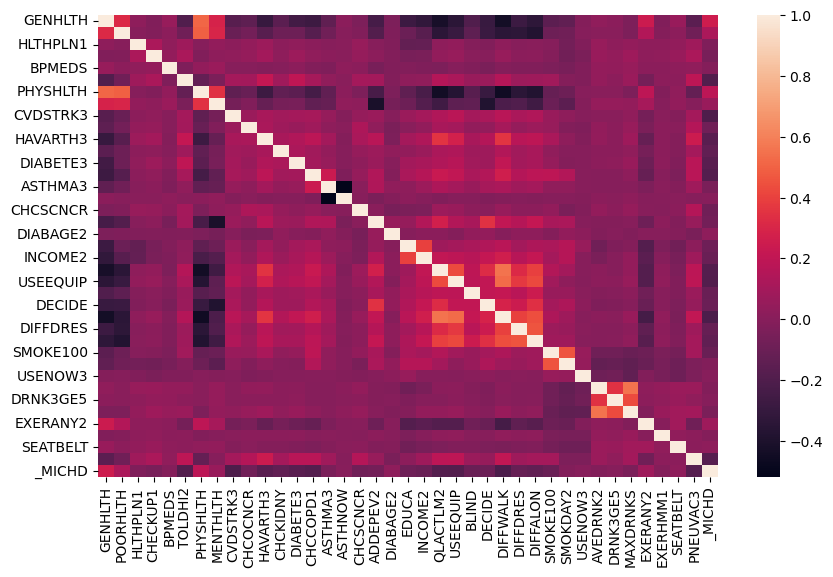

In [17]:
import seaborn  as sns
plt.figure(figsize=(10,6))
sns.heatmap(correlations,annot=False)

In [18]:
threshold=0.1
a=abs(correlations["_MICHD"])
result=a[a>threshold]
print(f"nb of selected features: {len(result)}")
list(result.index)

nb of selected features: 19


['GENHLTH',
 'POORHLTH',
 'TOLDHI2',
 'PHYSHLTH',
 'CVDSTRK3',
 'HAVARTH3',
 'CHCKIDNY',
 'DIABETE3',
 'CHCCOPD1',
 'INCOME2',
 'QLACTLM2',
 'USEEQUIP',
 'BLIND',
 'DIFFWALK',
 'DIFFDRES',
 'DIFFALON',
 'SMOKE100',
 'PNEUVAC3',
 '_MICHD']

In [19]:
selected_features=list(result.index)
selected_features.remove("_MICHD")

In [20]:
x_tr_cleaned=x_tr_cleaned[selected_features].copy(deep=True)

#### Split data

In [21]:
x_tra, x_val, y_tra, y_val=split_data(x_tr_cleaned.values,y_tr_cleaned.values.ravel(),ratio=0.75,seed=69)

In [22]:
def make_predictions(x,w,threshold,apply_sigmoid):
    w2=w.ravel()
    y_pred=x.dot(w2.T)
    if threshold==None:
        threshold=0.5
    if apply_sigmoid:
        y_pred=sigmoid(y_pred)
    y_pred=np.array([0 if prediction<threshold else 1 for prediction in y_pred])
    return y_pred
def compute_scores(x,w,y,threshold=None,apply_sigmoid=False):
    y_pred=make_predictions(x,w,threshold,apply_sigmoid) 
    TP=np.sum(np.logical_and(y_pred==1,y==1))
    FP=np.sum(np.logical_and(y_pred==1,y==0))
    FN=np.sum(np.logical_and(y_pred==0,y==1))
    precision=TP/(TP+FP)
    recall=TP/(TP+FN)
    f1=2*precision*recall/(precision+recall)
    return precision,recall,f1
    
x_tra_scaled=(x_tra-np.mean(x_tra,axis=0)[None,:])/np.std(x_tra,axis=0)
x_val_scaled=(x_val-np.mean(x_tra,axis=0)[None,:])/np.std(x_tra,axis=0)

In [23]:
np.where(y_tra==1)[0].shape[0]/y_tra.shape[0]

0.08872373537693874

In [24]:
required_ones = int(0.3 * len(y_tra))
existing_ones_indices = np.where(y_tra == 1)[0]
zeros_indices = np.where(y_tra == 0)[0]
np.random.seed(69)
ones_indices = np.random.choice(existing_ones_indices, required_ones - len(existing_ones_indices), replace=True)
zeros_indices=np.random.choice(zeros_indices,len(y_tra)-required_ones,replace=False)
result_indices = np.concatenate([existing_ones_indices, ones_indices,zeros_indices])

In [25]:
x_tra_scaled1=x_tra_scaled[result_indices].copy()
y_tra1=y_tra[result_indices].copy()

In [26]:
def build_mixe_features(x,features_names:list):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # polynomial basis function: TODO
    # this function should return the matrix formed
    # by applying the polynomial basis to the input data
    # ***************************************************
  
    # ***************************************************
    poly=np.array([[x[i,k]*col for col in [1]+[x[i,j] for j in range(x.shape[1])] for k in range(x.shape[1])] for i in range(x.shape[0])])
    new_features_name=[feature for feature in features_names]+[feature1+"*"+feature2 for feature1 in features_names for feature2 in features_names]
    return poly,new_features_name

In [38]:
x_tra_scaled1.shape

(246101, 18)

In [39]:
x_tra_poly,new_features=build_mixe_features(x_tra_scaled1,selected_features)
x_val_poly=build_mixe_features(x_val_scaled,selected_features)[0]

In [28]:
x_tra_poly-(x_tra_poly-np.mean(x_tra_poly,axis=0)[None,:])/np.std(x_tra_poly,axis=0)
x_val_poly=(x_val_poly-np.mean(x_tra_poly,axis=0)[None,:])/np.std(x_tra_poly,axis=0)

In [41]:
x_tra_poly.shape

(246101, 342)

## The NN model :

In [48]:
class MultLayerNN:
    def __init__(self, layer_sizes, lr=0.3, lr_decay=0.95, min_lr=0.001, l2_lambda=0.01):
        # Initialize the weights and biases for the input and hidden layers
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes)
        self.lr = lr
        self.lr_decay = lr_decay
        self.min_lr = min_lr
        self.l2_lambda = l2_lambda

        self.weights = [np.random.rand(layer_sizes[i], layer_sizes[i+1]) for i in range(self.num_layers - 1)]
        self.biases = [np.zeros((1, size)) for size in layer_sizes[1:]]

    def forward(self, x):
        # Forward propagation
        self.activations = [x]
        self.weighted_inputs = []

        for i in range(self.num_layers - 1):
            z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            self.weighted_inputs.append(z)
            a = sigmoid(z)
            self.activations.append(a)

        return self.activations[-1]

    def backward(self, x, y):
        # Backpropagation with cross-entropy loss and L2 regularization

        # Initialize deltas for each layer
        deltas = [None] * (self.num_layers - 1)

        # Calculate the error and delta for the output layer
        output = self.forward(x)
        error = y - output
        deltas[-1] = error

        # Backpropagate the deltas through the hidden layers
        for i in range(self.num_layers - 2, 0, -1):
            try:
            # Calculate gradients and deltas for this layer
                delta_weights = self.activations[i].T.dot(deltas[i]) - 2 * self.l2_lambda * self.weights[i]
                delta_biases = np.sum(deltas[i], axis=0, keepdims=True)
                deltas[i-1] = deltas[i].dot(self.weights[i].T) * self.activations[i] * (1 - self.activations[i])

                # Update weights and biases for this layer
                self.weights[i] += delta_weights * self.lr
                self.biases[i] += delta_biases * self.lr
            except:
                assert False

        # Update weights and biases for the input-to-hidden layer
        delta_weights = x.reshape(-1, 1).dot(deltas[0]) - 2 * self.l2_lambda * self.weights[0]
        delta_biases = np.sum(deltas[0], axis=0, keepdims=True)

        self.weights[0] += delta_weights * self.lr
        self.biases[0] += delta_biases * self.lr


    def train(self, X, y, epochs, batching=True, batch_size=16):
        show_loss_every = 100 if batching else 1
        show_f1_every = 1000 if batching else 1
        prev_loss = float('inf')  # Store previous loss to check for stagnation
        consecutive_bad_epochs = 0

        for epoch in range(epochs):
            indices = np.arange(len(X))
            np.random.shuffle(indices)

            if batching:
                batch_indices = indices[:batch_size]
            else:
                batch_indices = indices

            x_batch = X[batch_indices]
            y_batch = y[batch_indices]

            for j in range(len(x_batch)):
                x = x_batch[j]
                target = y_batch[j]
                self.backward(x, target)

            loss = self.calculate_cross_entropy_loss(X, y)
            if epoch % show_loss_every == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")
                print(f"Learning rate: {self.lr}")

            if epoch % show_f1_every == 0:
                f1 = self.compute_f1_score(X, y)
                print(f"Epoch {epoch}, F1 Score: {f1:.4f}")

            # Decay the learning rate
            if loss > prev_loss:
                consecutive_bad_epochs += 1
                if consecutive_bad_epochs >= 3:
                    self.lr *= self.lr_decay  # Decrease the learning rate
            else:
                consecutive_bad_epochs = 0

            prev_loss = loss

            # Ensure the learning rate doesn't go below a minimum value
            if self.lr < self.min_lr:
                self.lr = self.min_lr

    def predict(self, x):
        return np.round(self.forward(x))

    def calculate_cross_entropy_loss(self, X, y):
        predictions = self.forward(X)
        # Avoid division by zero and numerical instability
        epsilon = 1e-15
        predictions = np.clip(predictions, epsilon, 1 - epsilon)
        loss = - (y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
        return np.mean(loss)
    def compute_f1_score(self, X, y):
        true_positives = 0
        false_positives = 0
        false_negatives = 0

        predictions = []

        for i in range(len(X)):
            x = X[i]
            target = y[i]
            prediction = self.predict(x)
            predictions.append(prediction)  # Store predictions

            if target == 1 and prediction == 1:
                true_positives += 1
            elif target == 0 and prediction == 1:
                false_positives += 1
            elif target == 1 and prediction == 0:
                false_negatives += 1
        if true_positives==0 and (false_positives==0 or false_negatives==0):
            return 0
        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        
        # Calculate F1 score
        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

        return f1

In [50]:
input_size = x_tra_scaled.shape[1]
hidden_size = 2*int(len(selected_features)*2/3)+1
output_size = 1
model = NeuralNetwork(input_size, hidden_size, output_size)
#model=MultLayerNN(layer_sizes=[input_size,int(hidden_size/2),int(hidden_size/2),output_size])
# Train the model
model.train(x_tra_scaled1, y_tra1.reshape(-1,1), epochs=1000,batching=True,batch_size=16)

Epoch 0, Loss: 0.5850
learning rate: 0.3
Epoch 0, F1 Score: 0.0031
Epoch 100, Loss: 0.8328
learning rate: 0.27075
Epoch 200, Loss: 0.5336
learning rate: 0.18907482291738273
Epoch 300, Loss: 0.7175
learning rate: 0.13203800059552961
Epoch 400, Loss: 0.5601
learning rate: 0.08321687193655013
Epoch 500, Loss: 0.5244
learning rate: 0.06778066229776968
Epoch 600, Loss: 0.4892
learning rate: 0.04733376443646804
Epoch 700, Loss: 0.4685
learning rate: 0.04058278628371678
Epoch 800, Loss: 0.4753
learning rate: 0.03479466639000167
Epoch 900, Loss: 0.4688
learning rate: 0.033054933070501585


In [51]:
print(model.compute_f1_score(x_tra_scaled1,y_tra1.reshape(-1,1)))
print(model.compute_f1_score(x_tra_scaled,y_tra.reshape(-1,1)))
print(model.compute_f1_score(x_val_scaled,y_val.reshape(-1,1)))

0.6123183711875849
0.3719051014273931
0.36471729139435843


#### With features interactions:

In [114]:
input_size = x_tra_poly.shape[1]
hidden_size = int(x_tra_poly.shape[1]*2/3)+1
output_size = 1
model_poly = NeuralNetwork(input_size, hidden_size, output_size)
#model=MultLayerNN(layer_sizes=[input_size,int(hidden_size/2),int(hidden_size/2),output_size])
# Train the model
model_poly.train(x_tra_poly, y_tra1.reshape(-1,1), epochs=1000,batching=True,batch_size=32)

Epoch 0, Loss: 1.6134
learning rate: 0.3
Epoch 0, F1 Score: 0.4610
Epoch 100, Loss: 2.6582
learning rate: 0.27075
Epoch 200, Loss: 2.8400
learning rate: 0.24435187499999994
Epoch 300, Loss: 1.7420
learning rate: 0.1706400276829379
Epoch 400, Loss: 1.4457
learning rate: 0.15400262498385145
Epoch 500, Loss: 1.1713
learning rate: 0.13203800059552961
Epoch 600, Loss: 0.9927
learning rate: 0.11320608076059219
Epoch 700, Loss: 0.7670
learning rate: 0.07905602833972261
Epoch 800, Loss: 0.9755
learning rate: 0.058113445337550265
Epoch 900, Loss: 0.6124
learning rate: 0.04058278628371678


In [116]:
print(model_poly.compute_f1_score(x_tra_poly,y_tra1.reshape(-1,1)))
print(model_poly.compute_f1_score(x_val_poly,y_val.reshape(-1,1)))

0.6199572688843963
0.16084101077717583


## Ridge regression for feature selection

(0.6746664621990492, 0.4767167817960179, 0.5586755345322942)
(0.3073634618740185, 0.49341736694677873, 0.37877647564777983)


C:\Users\Alexi\AppData\Local\Temp\ipykernel_3600\2432430487.py:15: RuntimeWarning: invalid value encountered in scalar divide
  precision=TP/(TP+FP)


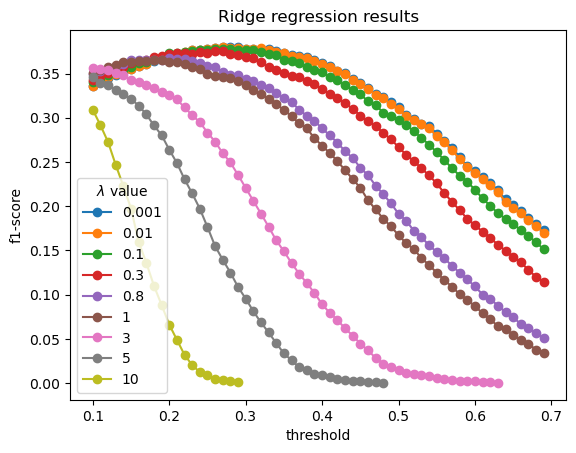

In [30]:
w_opt,loss=ridge_regression(y_tra1,x_tra_scaled1,lambda_=0.01)
print(compute_scores(x_tra_scaled1,w_opt,y=y_tra1,threshold=0.3,apply_sigmoid=False))
print(compute_scores(x_val_scaled,w_opt,y=y_val,threshold=0.29,apply_sigmoid=False))
thr_l=np.arange(0.1,0.7,0.01)
for lambda_ in [0.001,0.01,0.1,0.3,0.8,1,3,5,10]:
    w_opt,loss=ridge_regression(y_tra1,x_tra_scaled1,lambda_=lambda_)
    
    f1_scores=[compute_scores(x_val_scaled,w_opt,y_val,threshold=t,apply_sigmoid=False)[2] for t in thr_l]
    plt.plot(thr_l,f1_scores,marker='o',label=str(lambda_))
    plt.xlabel("threshold")
    plt.ylabel("f1-score")
plt.legend(title="$\\lambda$ value")
plt.title("Ridge regression results")
plt.show()

In [33]:
w_opt,loss=ridge_regression(y_tra1,x_tra_scaled1,lambda_=0.01)
print(compute_scores(x_val_scaled,w_opt,y=y_val,threshold=0.29,apply_sigmoid=False))

(0.3073634618740185, 0.49341736694677873, 0.37877647564777983)


#### With polynomial interactions: 

In [43]:
w_opt,loss=ridge_regression(y_tra1,x_tra_poly,lambda_=0.01)

(0.6487591572491339, 0.4642015440877692, 0.5411781425424571)
(0.27783291976840363, 0.4704481792717087, 0.3493499739989599)


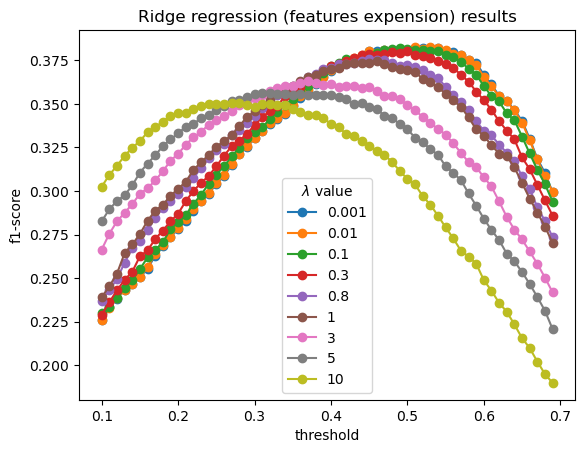

In [46]:

print(compute_scores(x_tra_poly,w_opt,y=y_tra1,threshold=0.3,apply_sigmoid=False))
print(compute_scores(x_val_poly,w_opt,y=y_val,threshold=0.29,apply_sigmoid=False))
thr_l=np.arange(0.1,0.7,0.01)
for lambda_ in [0.001,0.01,0.1,0.3,0.8,1,3,5,10]:
    w_opt,loss=ridge_regression(y_tra1,x_tra_poly,lambda_=lambda_)
    
    f1_scores=[compute_scores(x_val_poly,w_opt,y_val,threshold=t,apply_sigmoid=False)[2] for t in thr_l]
    plt.plot(thr_l,f1_scores,marker='o',label=str(lambda_))
    plt.xlabel("threshold")
    plt.ylabel("f1-score")
plt.legend(title="$\\lambda$ value")
plt.title("Ridge regression (features expension) results")
plt.show()

In [48]:
w_opt,loss=ridge_regression(y_tra1,x_tra_poly,lambda_=0.01)
print(compute_scores(x_val_poly,w_opt,y=y_val,threshold=0.55,apply_sigmoid=False))

(0.34388732394366195, 0.42745098039215684, 0.3811426787386824)


### Logistic regression

In [57]:
w_opt_log,loss=logistic_regression(y_tra1,x_tra_scaled1,initial_w=np.zeros((x_tra_scaled1.shape[1],1)),max_iters=15,gamma=0.2,gd=True)

In [58]:
compute_scores(x_val_scaled,w_opt_log,y_val,threshold=0.68,apply_sigmoid=True)

(0.30008841732979663, 0.4753501400560224, 0.3679132791327913)

Text(0, 0.5, 'f1-score')

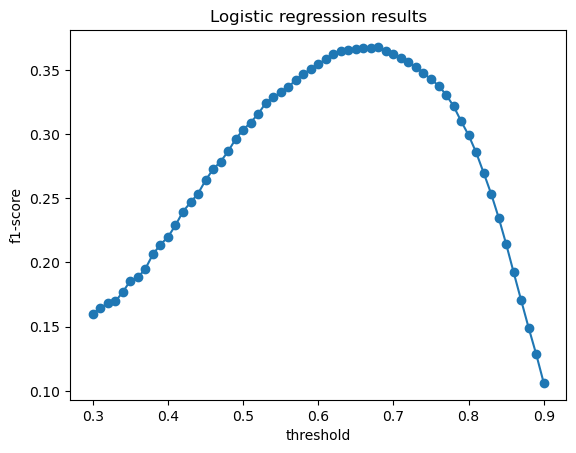

In [60]:
thr_l=np.arange(0.3,0.9,0.01)
f1_scores=[compute_scores(x_val_scaled,w_opt_log,y_val,threshold=t,apply_sigmoid=True)[2] for t in thr_l]
plt.plot(thr_l,f1_scores,marker='o')
plt.title("Logistic regression results")
plt.xlabel("threshold")
plt.ylabel("f1-score")

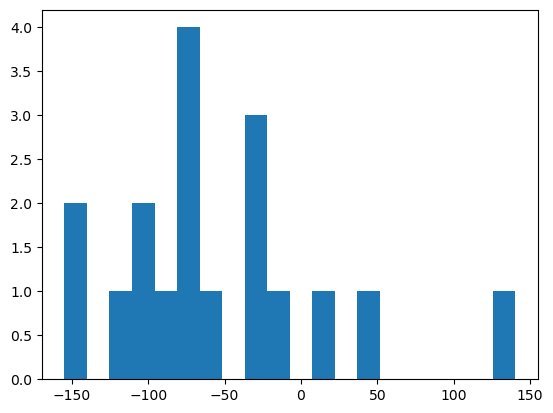

In [69]:
plt.hist(w_opt_log*1000,bins=20)
plt.show()

In [76]:
np.array(selected_features)[np.argpartition(np.abs(w_opt_log),-5,axis=0)][-5:]

array([['CHCCOPD1'],
       ['PNEUVAC3'],
       ['CVDSTRK3'],
       ['TOLDHI2'],
       ['GENHLTH']], dtype='<U8')

### Penalized log regression: 

In [49]:
def penalized_logistic_regression(y, tx, w, lambda_):
    """return the loss and gradient.

    Args:
        y:  shape=(N, 1)
        tx: shape=(N, D), D is the number of features.
        w:  shape=(D,)
        lambda_: scalar

    Returns:
        loss: scalar number
        gradient: shape=(D,)"""

    loss = calculate_logistic_loss(y, tx, w) + lambda_ * np.squeeze(w.T @ w)
    gradient = calculate_logistic_gradient(y, tx, w) + 2 * lambda_ * w

    return loss, gradient


def learning_by_penalized_gradient(y, tx, w, gamma, lambda_):
    """
    Do one step of gradient descent, using the penalized logistic regression.
    Return the loss and updated w.

    Args:
        y:  shape=(N, 1)
        tx: shape=(N, D), D is the number of features.
        w:  shape=(D,)
        gamma: scalar
        lambda_: scalar

    Returns:
        loss: scalar number
        w: shape=(D,)"""
    loss, penalized_gradient = penalized_logistic_regression(y, tx, w, lambda_)

    w -= gamma * penalized_gradient
    new_loss = calculate_logistic_loss(y, tx, w)
    return w, new_loss


def reg_logistic_regression(y, tx, lambda_, initial_w, max_iters, gamma):
    """
    Compute the regularized logistic regression.

    Args:
        y:  shape=(N, 1)
        tx: shape=(N, D), D is the number of features.
        max_iter: int
        initial_w:  shape=(D,)
        gamma: scalar
        lambda_: scalar

    Returns:
        w: shape=(D,)
        loss: scalar number
    """
    w = initial_w
    loss = calculate_logistic_loss(y, tx, w)

    for n in range(max_iters):
        w, loss = learning_by_penalized_gradient(y, tx, w, gamma, lambda_)

    return w, loss


def my_reg_logistic_regression(
    y_tr, x_tr, y_val, x_val, lambda_, initial_w, max_iters, gamma
):
    """
    Compute the regularized logistic regression.

    Args:
        y:  shape=(N, 1)
        tx: shape=(N, D), D is the number of features.
        max_iter: int
        initial_w:  shape=(D,)
        gamma: scalar
        lambda_: scalar

    Returns:
        w: shape=(D,)
        loss: scalar number
    """
    w = initial_w
    loss = calculate_logistic_loss(y_tr, x_tr, w)
    gen_loss = calculate_logistic_loss(y_val, x_val, w)

    losses = [loss]
    gen_losses = [gen_loss]

    for n in range(max_iters):
        w, loss = learning_by_penalized_gradient(y_tr, x_tr, w, gamma, lambda_)
        losses.append(np.abs(loss))
        gen_losses.append(np.abs(calculate_logistic_loss(y_val, x_val, w)))

    return w, losses, gen_losses

In [55]:
w, losses=reg_logistic_regression(y_tra1,x_tra_scaled1,lambda_=0.01,initial_w=np.zeros((x_tra_scaled1.shape[1],1)),max_iters=15,gamma=0.2)

Text(0, 0.5, 'f1-score')

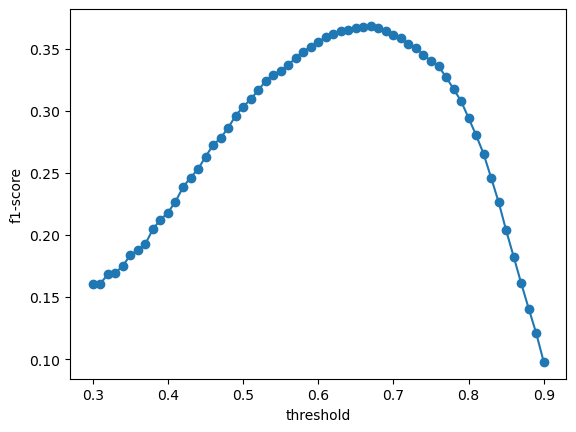

In [56]:
thr_l=np.arange(0.3,0.9,0.01)
f1_scores=[compute_scores(x_val_scaled,w,y_val,threshold=t,apply_sigmoid=True)[2] for t in thr_l]
plt.plot(thr_l,f1_scores,marker='o')
plt.xlabel("threshold")
plt.ylabel("f1-score")

#### With features interactions: 

In [102]:
w_opt_log,loss=logistic_regression(y_tra1,x_tra_poly,initial_w=np.zeros((x_tra_poly.shape[1],1)),max_iters=15,gamma=0.2,gd=True)

In [109]:
compute_scores(x_val_poly,w_opt_log,y_val,threshold=0.87,apply_sigmoid=True)

(0.286261836765369, 0.5334733893557423, 0.3725912158857478)

Text(0, 0.5, 'f1-score')

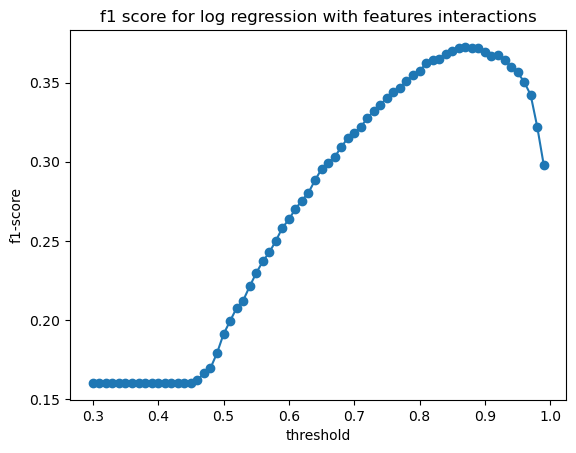

In [117]:
thr_l=np.arange(0.3,1,0.01)
f1_scores=[compute_scores(x_val_poly,w_opt_log,y_val,threshold=t,apply_sigmoid=True)[2] for t in thr_l]
plt.plot(thr_l,f1_scores,marker='o')
plt.title("f1 score for log regression with features interactions")
plt.xlabel("threshold")
plt.ylabel("f1-score")

In [104]:
from sklearn.linear_model import LogisticRegression

In [105]:
modellog=LogisticRegression()
modellog.fit(x_tra_poly,y_tra1)

LogisticRegression()

In [106]:
modellog.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}